In [1]:
# Import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import hvplot.pandas
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Read In and Clean Data

In [2]:
# Read in data from csv file
wine_data = Path("Resources/winemag-data-130k-v2.csv")
# Convert to dataframe
wine_df = pd.read_csv(wine_data)
wine_df.head(5)

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
# Clean and transform data
# Drop unnecessary columns
df = wine_df.loc[:,["country", "description", "points",
                                    "province", "variety"]]
# Drop null values
df = df.dropna(how='any')
df.head(5)

,country,description,points,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Douro,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Michigan,Riesling
4,US,"Much like the regular bottling from 2012, this...",87,Oregon,Pinot Noir


In [4]:
# List number of descriptions for each country
df["country"].value_counts()

US                        54504
France                    22093
Italy                     19540
Spain                      6645
Portugal                   5691
Chile                      4471
Argentina                  3800
Austria                    3345
Australia                  2329
Germany                    2165
New Zealand                1419
South Africa               1401
Israel                      505
Greece                      466
Canada                      257
Hungary                     146
Bulgaria                    141
Romania                     120
Uruguay                     109
Turkey                       90
Slovenia                     87
Georgia                      86
England                      74
Croatia                      73
Mexico                       70
Moldova                      59
Brazil                       52
Lebanon                      35
Morocco                      28
Peru                         16
Ukraine                      14
Serbia  

In [5]:
# Store the value counts as a variable
values = df["country"].value_counts() 

In [6]:
# Create list of country names to keep
countries_to_keep = ["US", "France", "Italy", "Spain", "Portugal", "Chile", "Argentina", "Austria",
                  "Australia", "Germany", "New Zealand", "South Africa"]

In [7]:
# Drop countries with less than 1000 descriptions
# Choose cutoff value to create list of countries
countries_to_replace = values.index[values<1000]

# Replace in dataframe
for ctry in countries_to_replace:
    df["country"] = df["country"].replace(ctry, "Other")

# Check to make sure binning was successful
df["country"].value_counts()

reduced_df=df.loc[df["country"].isin(countries_to_keep), :]
reduced_df.head()


,country,description,points,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,Douro,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,Michigan,Riesling
4,US,"Much like the regular bottling from 2012, this...",87,Oregon,Pinot Noir


# Preprocess Data to Build Word2Vec Model

In [8]:
# Transform words into vectors using NLP
# Drop stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
reduced_df['description'] = reduced_df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
reduced_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\katyp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\katyp\AppData\Local\Temp\ipykernel_25416\608277938.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['description'] = reduced_df['description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


,country,description,points,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend
1,Portugal,"This ripe fruity, wine smooth still structured...",87,Douro,Portuguese Red
2,US,"Tart snappy, flavors lime flesh rind dominate....",87,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith orange blossom star...",87,Michigan,Riesling
4,US,"Much like regular bottling 2012, comes across ...",87,Oregon,Pinot Noir


In [9]:
# Lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)
reduced_df['description'] = reduced_df['description'].apply(lemmatize_words)
reduced_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\katyp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\katyp\AppData\Local\Temp\ipykernel_25416\2083711034.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['description'] = reduced_df['description'].apply(lemmatize_words)


,country,description,points,province,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend
1,Portugal,"This ripe fruity, wine smooth still structured...",87,Douro,Portuguese Red
2,US,"Tart snappy, flavor lime flesh rind dominate. ...",87,Oregon,Pinot Gris
3,US,"Pineapple rind, lemon pith orange blossom star...",87,Michigan,Riesling
4,US,"Much like regular bottle 2012, come across rat...",87,Oregon,Pinot Noir


In [10]:
# Tokenize descriptions to split sentences into word components
descriptions = reduced_df.description.apply(gensim.utils.simple_preprocess)
descriptions

0         [aromas, include, tropical, fruit, broom, brim...
1         [this, ripe, fruity, wine, smooth, still, stru...
2         [tart, snappy, flavor, lime, flesh, rind, domi...
3         [pineapple, rind, lemon, pith, orange, blossom...
4         [much, like, regular, bottle, come, across, ra...
                                ...                        
129966    [notes, honeysuckle, cantaloupe, sweeten, deli...
129967    [citation, give, much, decade, bottle, age, pr...
129968    [well, drained, gravel, soil, give, wine, cris...
129969    [dry, style, pinot, gris, crisp, acidity, it, ...
129970    [big, rich, off, dry, power, intense, spicines...
Name: description, Length: 127403, dtype: object

In [11]:
# Word2Vec model
# Create the model
model = gensim.models.Word2Vec(window=1, min_count=1, workers=8)
# Build its vocabulary
model.build_vocab(descriptions, progress_per=100)
# Train the model
model.train(descriptions, total_examples=model.corpus_count, epochs= model.epochs)
# Save the model to use later
model.save("Resources/descriptions.model")

In [12]:
# Test the model looking for similar words
model.wv.most_similar("bright")

[('vibrant', 0.8069656491279602),
 ('lively', 0.7426486015319824),
 ('fragrant', 0.725641131401062),
 ('buoyant', 0.7205615043640137),
 ('zippy', 0.7072540521621704),
 ('pristine', 0.6911181807518005),
 ('vivid', 0.6896920800209045),
 ('fresh', 0.6895458102226257),
 ('vivacious', 0.6888056993484497),
 ('zesty', 0.6749471426010132)]

In [13]:
# Test the model with similarity of different words
model.wv.similarity(w1="sweet",w2="fruity")

0.4081564

# Calculate Vector Representations of Descriptions

In [14]:
# Get vector representations of descriptions
# Define our function that creates description vectors:
def get_desc_vec(document):
    return np.array(sum(model.wv[word] for word in document)/len(document))

desc_vecs = descriptions.apply(get_desc_vec).tolist()


In [15]:
desc_vec_df = pd.DataFrame(desc_vecs)

In [16]:
desc_vec_df.values

array([[-0.54843515,  0.17253916, -0.29185882, ..., -0.01022042,
        -0.18290213,  0.67553073],
       [-0.57672954, -0.00861365,  0.07475142, ..., -0.10169392,
         0.17427133,  0.25443217],
       [-0.36969241,  0.04136235, -0.10023174, ..., -0.15868627,
        -0.07754678,  0.44245458],
       ...,
       [-0.5178596 ,  0.03649308, -0.13822904, ..., -0.10460812,
         0.15002166,  0.13125159],
       [-0.4056922 ,  0.03822115, -0.17912327, ...,  0.05585825,
         0.02984309,  0.27077797],
       [-0.39370593,  0.10916886, -0.11118394, ...,  0.03083264,
         0.16965368,  0.33721754]], dtype=float32)

# Build TSNE Model

In [17]:
# Save the labels into a variable l.
l = reduced_df['country']
 
# Drop the label feature and 
# Store the pixel data in d.
d = reduced_df.drop("description", axis=1)

In [18]:
# Data-preprocessing: Standardizing the data
standardized_data = StandardScaler().fit_transform(desc_vecs)
print(standardized_data.shape)

(127403, 100)


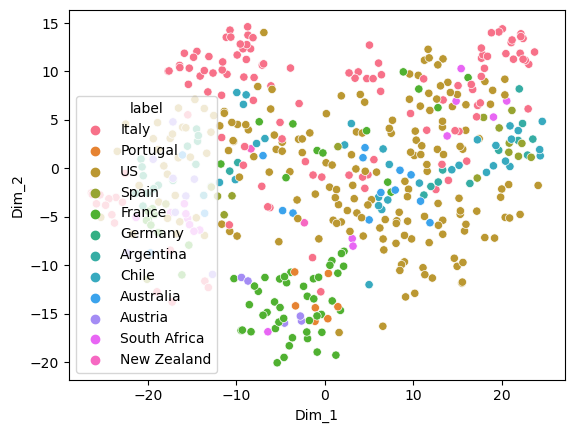

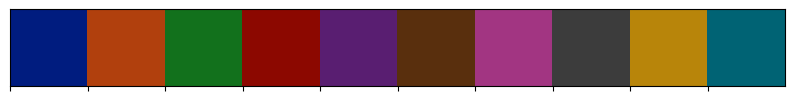

In [19]:
# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points
data_500 = standardized_data[0:500, :]
labels_500 = l[0:500]
 
model = TSNE(n_components = 2, random_state = 0)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000
 
tsne_data = model.fit_transform(data_500)
 
# creating a new data frame which
# help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_500)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))
 
# Plotting the result of tsne
sns.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2',
               hue='label')
custom_palette = sns.color_palette("dark")
sns.palplot(custom_palette)
plt.show()

# Build KMeans Clusters

In [20]:
# Elbow Method to find the optimal number of clusters
num_clusters_range = range(1, 11)

wcss = []
for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init = "auto")
    kmeans.fit(desc_vec_df)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for the elbow curve
df_elbow = pd.DataFrame({"k_value": num_clusters_range, "inertia_value": wcss})

# Plot the elbow curve using hvplot
elbow_curve = df_elbow.hvplot.line(x="k_value", y="inertia_value", title="Elbow Curve")
elbow_curve

:Curve   [k_value]   (inertia_value)

In [21]:
# Apply k-means clustering with the optimal number of clusters
optimal_k = 4 # Add the optimal k value based on the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init = "auto")
cluster_assignments_kmeans = kmeans.fit_predict(desc_vec_df)

# Add the cluster assignments to new dataframe
desc_vec_kmeans_predictions_df = reduced_df.copy()
desc_vec_kmeans_predictions_df['kmeans_cluster'] = cluster_assignments_kmeans

# Plot the clusters
#desc_vec_pca_predictions_df.hvplot.scatter(
    #x="PCA1",
    #y="PCA2",
    #by="kmeans_cluster"
#)

In [22]:
# Display the clusters
for cluster_id in range(optimal_k):
    print(f"Cluster {cluster_id}:")
    print(desc_vec_kmeans_predictions_df[desc_vec_kmeans_predictions_df['kmeans_cluster'] == cluster_id]['variety'].value_counts().head())
    print("\n")

Cluster 0:
Red Blend             5643
Cabernet Sauvignon    4530
Pinot Noir            4186
Nebbiolo              2242
Syrah                 2145
Name: variety, dtype: int64


Cluster 1:
Chardonnay         6091
Riesling           4035
Sauvignon Blanc    3033
White Blend        1431
Sparkling Blend    1396
Name: variety, dtype: int64


Cluster 2:
Pinot Noir                  6304
Cabernet Sauvignon          4195
Chardonnay                  3049
Red Blend                   2527
Bordeaux-style Red Blend    1925
Name: variety, dtype: int64


Cluster 3:
Bordeaux-style Red Blend    3771
Chardonnay                  2304
Pinot Noir                  2191
Portuguese Red              1990
Rosé                        1376
Name: variety, dtype: int64




# Utilize PCA Followed by KMeans Clustering

In [23]:
# Instantiate the PCA instance and declare the number of PCA variables
pca = PCA(n_components=2)

In [24]:
# Fit the PCA model on the vectors DataFrame
desc_vec_pca = pca.fit_transform(desc_vec_df)

# Review the first 5 rows of list data
desc_vec_pca[:5]

array([[-0.79823965,  0.48378435],
       [ 0.41630092, -0.1238037 ],
       [-0.24189757,  1.0892144 ],
       [-0.69882214,  1.0349097 ],
       [ 0.90828466, -0.33220991]], dtype=float32)

In [25]:
# Calculate the PCA explained variance ratio
pca.explained_variance_ratio_
print(pca.explained_variance_ratio_)
print("Total explained variance = .29")

[0.16075532 0.12782244]
Total explained variance = .29


In [26]:
# Create the PCA DataFrame
desc_vec_pca_df = pd.DataFrame(
    desc_vec_pca,
    columns=["PCA1", "PCA2"]
)

# Review the PCA DataFrame
desc_vec_pca_df.head()

,PCA1,PCA2
0,-0.798240,0.483784
1,0.416301,-0.123804
2,-0.241898,1.089214
3,-0.698822,1.034910
4,0.908285,-0.332210


In [27]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1, n_init = "auto")
    k_model.fit(desc_vec_pca_df)
    inertia.append(k_model.inertia_)

# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,73938.734375
1,2,46687.101562
2,3,26519.439453
3,4,20801.771484
4,5,15964.880859


In [28]:
# Plot the Elbow Curve
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)


:Curve   [k]   (inertia)

In [29]:
# Determine optimal number of clusters based on elbow frame above
print("Optimal number of clusters = 5")

Optimal number of clusters = 5


In [30]:
# Define the model with 5 clusters
cluster_number = 5
model = KMeans(n_clusters=cluster_number, random_state=1, n_init = "auto")

# Fit the model
model.fit(desc_vec_pca_df)

# Make predictions
k_5 = model.predict(desc_vec_pca_df)

# Create a copy of the PCA DataFrame
pca_to_cluster_df=desc_vec_pca_df.copy()

# Add a class column with the labels
pca_to_cluster_df["pca_clusters"] = k_5
pca_to_cluster_df.head()

,PCA1,PCA2,pca_clusters
0,-0.798240,0.483784,2
1,0.416301,-0.123804,3
2,-0.241898,1.089214,2
3,-0.698822,1.034910,2
4,0.908285,-0.332210,3


In [31]:
# Plot the clusters
pca_to_cluster_df.hvplot.scatter(
    x="PCA1",
    y="PCA2",
    by="pca_clusters"
)

:NdOverlay   [pca_clusters]
   :Scatter   [PCA1]   (PCA2)

In [32]:
# Create a copy of the cleaned df
desc_vec_pca_predictions_df = reduced_df.copy()

# Add a class column with the labels
desc_vec_pca_predictions_df["pca_clusters"] = k_5

for cluster_id in range(cluster_number):
    print(f"Cluster {cluster_id}:")
    print(desc_vec_pca_predictions_df[desc_vec_pca_predictions_df['pca_clusters'] == cluster_id]['variety'].value_counts().head())
    print("\n")

Cluster 0:
Chardonnay         5625
Sauvignon Blanc    2480
Riesling           2110
Rosé               1644
Pinot Noir         1099
Name: variety, dtype: int64


Cluster 1:
Red Blend             3706
Cabernet Sauvignon    2403
Nebbiolo              1912
Pinot Noir            1894
Sangiovese            1660
Name: variety, dtype: int64


Cluster 2:
Chardonnay         3911
Riesling           2746
Sauvignon Blanc    1856
Sparkling Blend     927
Rosé                848
Name: variety, dtype: int64


Cluster 3:
Pinot Noir                  4162
Bordeaux-style Red Blend    2808
Cabernet Sauvignon          2585
Chardonnay                  1561
Red Blend                   1363
Name: variety, dtype: int64


Cluster 4:
Pinot Noir                  5685
Cabernet Sauvignon          4196
Red Blend                   3368
Bordeaux-style Red Blend    3312
Syrah                       2067
Name: variety, dtype: int64




# Display Final DataFrame with Comparison of Clusters

In [33]:
cluster_wine_df=reduced_df.copy()
cluster_wine_df["kmeans_cluster"]=cluster_assignments_kmeans
cluster_wine_df["pca_cluster"]=k_5
cluster_wine_df.head(20)

,country,description,points,province,variety,kmeans_cluster,pca_cluster
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,Sicily & Sardinia,White Blend,1,2
1,Portugal,"This ripe fruity, wine smooth still structured...",87,Douro,Portuguese Red,3,3
2,US,"Tart snappy, flavor lime flesh rind dominate. ...",87,Oregon,Pinot Gris,1,2
3,US,"Pineapple rind, lemon pith orange blossom star...",87,Michigan,Riesling,1,2
4,US,"Much like regular bottle 2012, come across rat...",87,Oregon,Pinot Noir,2,3
5,Spain,Blackberry raspberry aromas show typical Navar...,87,Northern Spain,Tempranillo-Merlot,0,1
6,Italy,"Here's bright, informal red open aromas candy ...",87,Sicily & Sardinia,Frappato,0,1
7,France,This dry restrain wine offer spice profusion. ...,87,Alsace,Gewürztraminer,3,0
8,Germany,Savory dry thyme note accent sunnier flavor pr...,87,Rheinhessen,Gewürztraminer,1,2
9,France,This great depth flavor fresh apple pear fruit...,87,Alsace,Pinot Gris,3,2


In [34]:
# Use TSNE as our clustering algorithm
# Build the TSNE model
#tsne_model=TSNE(metric='cosine', perplexity=50, n_components=2, learning_rate='auto',
                  #init='random')

In [35]:
#sorted_df["country"].value_counts()

In [36]:
# Fit the TSNE model
#tsne_model.fit(desc_vec_df)

In [37]:
# Make predictions about the wine recommendations based on the trained model
#wine_recs = tsne_model.predict(desc_vec_df)

In [38]:
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
# X_embedded = TSNE(n_components=2, learning_rate='auto',
                  #init='random', perplexity=3).fit_transform(X)
# X_embedded.shape


# For your data it would look something like
# df = yourDataFrame
# TSNE(metric='cosine', perplexity=50, n_components=2, learning_rate='auto',
                  #init='random', perplexity=3).fit_transform(df) (edited) 

In [39]:
#import string

#a red wine that does not smell like horse
#a red horse that does not smell like wine

#a tart not sweet wine
#a sweet wine not tart



#'your custom word here' in model.wv
#user_input = 'Red wine with, juicy..... fruity dessert flavors laser-like dkljgbioerubgowrbgowergbwoergb'

# Text box that takes user input js
# [  'Red wine with juicy fruity dessert flavors' ]  => pass to flask in a post

#'Red wine with juicy fruity dessert flavors'
#user_input_nopunc = user_input.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
#print(user_input)
#print(user_input_nopunc)
# in flask
#description = [word.lower().strip() for word in user_input_nopunc.split()]
#clean_description = [w for w in description if w in model.wv]
#sum(model.wv[word] for word in clean_description)
# take words in the description, get the vectors (if they exist), combine them and find similar with cosine similarity



# import your model
# import your description vectors

# Then  create routes and stuff


